# Stitching Map
---
### Imports

In [1]:
# Libraries needed
import os
import subprocess
from functools import partial
import re
from pathlib import Path
import json
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.transform import pyramid_reduce

import renderapi

### Initialize render

In [2]:
owner = 'rlane'  # replace with your name
project = 'iCAT_align'
stack = 'lil_EM'
match_collection = 'lil_EM_points'
project_dir = Path('/long_term_storage/rlane/SECOM/iCAT_sample_data')

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}

render = renderapi.connect(**render_connect_params)

### Get Tile Pair List

In [3]:
# Get positional bounds of image stack
stack_bounds = renderapi.stack.get_stack_bounds(stack, render=render)

# Only attempt to get tile pairs if stack contains >1 tiles
N_tiles = len(renderapi.stack.get_stack_tileIds(stack, render=render))

# Generate tile pairs for input into point match generator
tile_pairs = renderapi.client.tilePairClient(stack,
                                             minz=stack_bounds['minZ'],
                                             maxz=stack_bounds['maxZ'],
                                             render=render)

# Generate list of tile pairs    
tile_pair_list = [(tp['p']['id'], tp['q']['id']) for tp in tile_pairs['neighborPairs']]
        
# Preview first several tile pairs
tile_pair_list[:8]

[('aaa_lil_EM-00000x00005', 'aan_lil_EM-00000x00004'),
 ('aaa_lil_EM-00000x00005', 'aab_lil_EM-00001x00005'),
 ('aab_lil_EM-00001x00005', 'aam_lil_EM-00001x00004'),
 ('aab_lil_EM-00001x00005', 'aac_lil_EM-00002x00005'),
 ('aac_lil_EM-00002x00005', 'aal_lil_EM-00002x00004'),
 ('aac_lil_EM-00002x00005', 'aad_lil_EM-00003x00005'),
 ('aad_lil_EM-00003x00005', 'aak_lil_EM-00003x00004'),
 ('aad_lil_EM-00003x00005', 'aae_lil_EM-00004x00005')]

### Get Matches

In [4]:
p_matches = {}
q_matches = {}

for tile_pair in tile_pair_list:
    
    # Get group IDs
    groupIds = renderapi.pointmatch.get_match_groupIds(match_collection, render=render)
    
    tile_pair_matches = renderapi.pointmatch.get_matches_from_tile_to_tile(
                            match_collection,
                            pgroup=groupIds[0],
                            pid=tile_pair[0],
                            qgroup=groupIds[0],
                            qid=tile_pair[1],
                            render=render)
    
    # Suss out column and row number from tileId
    pc, pr = [int(i) for i in re.findall('\d+', tile_pair[0])]
    qc, qr = [int(i) for i in re.findall('\d+', tile_pair[1])]
    
    try:
        # Stuff matches into arrays
        p_matches_arr = np.array(tile_pair_matches[0]['matches']['p']).T
        q_matches_arr = np.array(tile_pair_matches[0]['matches']['q']).T
        # Ensure p and q matches check out
        assert len(p_matches_arr) == len(q_matches_arr)
    
    except IndexError:
        # No matches for this tile pair
        print(f"No matches for tile pair:  {tile_pair[0]} <--> {tile_pair[1]}")
        p_matches_arr = []
        q_matches_arr = []
        
    p_matches[((pr, pc), (qr, qc))] = p_matches_arr
    q_matches[((pr, pc), (qr, qc))] = q_matches_arr

### Make Mosaic

In [5]:
# Mosaic parameters
dsf = 2  # down sample factor
grid_shape = (6, 7)  # rows, cols of entire grid
thumb_shape = (2048//dsf, 2048//dsf)  # shape of each thumbnail image
mosaic = np.full(shape=(grid_shape[0]*thumb_shape[0], grid_shape[1]*thumb_shape[1]),
                 fill_value=2**15)

# Get tile specifications
tile_specs = renderapi.tilespec.get_tile_specs_from_stack(stack, render=render)

for tile in tile_specs[:]:
    
    c, r = [int(i) for i in re.findall('\d+', tile.tileId)]
    
    imageUrl = tile.to_dict()['mipmapLevels']['0']['imageUrl']
    img = imread(imageUrl)
    clipped = np.clip(img, a_min=tile.minint, a_max=tile.maxint)
    thumb = pyramid_reduce(clipped, downscale=dsf, multichannel=False)
    
    ii, ji = (r*2048//dsf, c*2048//dsf)
    ij, jj = (ii + 2048//dsf, ji + 2048//dsf)
    
    mosaic[ii:ij, ji:jj] = thumb

### Make Stitch Figure

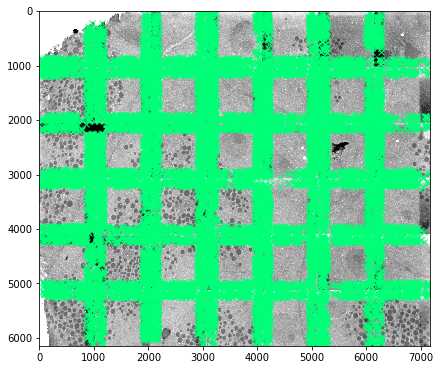

In [20]:
# Make plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(mosaic, cmap='Greys_r');

# Make stitch points
for ((pr, pc), (qr, qc)), matches in p_matches.items():
    ax.plot(matches[:,0]/dsf + pc*2048/dsf,
            matches[:,1]/dsf + pr*2048/dsf,
            'x', color='#00FF77');

for ((pr, pc), (qr, qc)), matches in q_matches.items():
    ax.plot(matches[:,0]/dsf + qc*2048/dsf,
            matches[:,1]/dsf + qr*2048/dsf,
            'x', color='#00FF77');

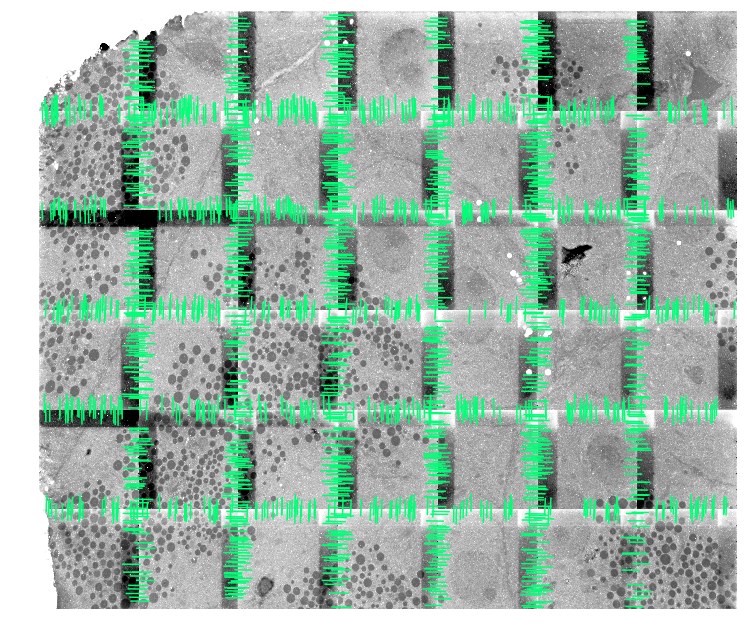

In [19]:
# Make plot
fig, ax = plt.subplots(figsize=(14, 11))
ax.imshow(mosaic, cmap='Greys_r');

# Make stitch lines
for (((pr, pc), (qr, qc)), pms), (((pr, pc), (qr, qc)), qms) in zip(p_matches.items(), q_matches.items()):
    lines = np.vstack((pms[:,0]/dsf + pc*2048/dsf,
                       qms[:,0]/dsf + qc*2048/dsf,
                       pms[:,1]/dsf + pr*2048/dsf,
                       qms[:,1]/dsf + qr*2048/dsf)).T[::4]
    
    ax.plot(*lines.reshape(-1, 2), color='#00FF77');
    
ax.axis('off');